In [ ]:
# Install required packages
!pip install yfinance pandas-datareader -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import warnings
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)

print("All libraries imported successfully")
print("Google Colab environment ready for FFT stock analysis")

All libraries imported successfully
Google Colab environment ready for FFT stock analysis


In [ ]:
# Stock Analysis Parameters
TICKER = 'AAPL'  # Change to any stock (GOOGL, TSLA, MSFT, etc.)
PERIOD_YEARS = 3  # Years of historical data
PREDICTION_DAYS = 30  # Days to predict ahead
TOP_FREQUENCIES = 25  # Number of dominant frequencies
MIN_PERIOD = 2  # Minimum cycle period (days)
MAX_PERIOD = 365  # Maximum cycle period (days)

# Display Configuration
FIGURE_SIZE = (15, 8)
DPI = 100

print(f"Analysis Configuration:")
print(f"  Stock: {TICKER}")
print(f"  Historical Period: {PERIOD_YEARS} years")
print(f"  Prediction Window: {PREDICTION_DAYS} days")
print(f"  Frequency Range: {MIN_PERIOD}-{MAX_PERIOD} days")


Analysis Configuration:
  Stock: AAPL
  Historical Period: 3 years
  Prediction Window: 30 days
  Frequency Range: 2-365 days


In [ ]:
def download_stock_data(ticker, period_years=3):
    """Download stock data with technical indicators"""
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(365 * period_years)

    try:
        print(f"Downloading {ticker} data...")
        # Use yfinance directly instead of pandas-datareader
        df = yf.download(ticker, start=start_date, end=end_date)

        if df.empty:
            print(f"No data found for {ticker}")
            return None

        # Calculate technical indicators
        df['Returns'] = df['Close'].pct_change()
        df['MA_20'] = df['Close'].rolling(window=20).mean()
        df['MA_50'] = df['Close'].rolling(window=50).mean()
        df['Volatility'] = df['Returns'].rolling(window=20).std()
        df['Price_Change'] = df['Close'].diff()
        df['Volume_MA'] = df['Volume'].rolling(window=20).mean()

        print(f"Successfully downloaded {len(df)} data points")

        # Fix: Extract dates as strings to avoid formatting issues
        start_date_str = df.index[0].strftime('%Y-%m-%d')
        end_date_str = df.index[-1].strftime('%Y-%m-%d')
        print(f"Date range: {start_date_str} to {end_date_str}")

        # Fix: Extract scalar values before formatting
        min_price = float(df['Close'].min())
        max_price = float(df['Close'].max())
        print(f"Price range: ${min_price:.2f} - ${max_price:.2f}")

        return df

    except Exception as e:
        print(f"Error in data processing: {e}")
        return None

def get_stock_info(ticker):
    """Get basic stock information"""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'name': info.get('longName', 'N/A'),
            'sector': info.get('sector', 'N/A'),
            'industry': info.get('industry', 'N/A'),
            'market_cap': info.get('marketCap', 'N/A'),
            'currency': info.get('currency', 'USD')
        }
    except Exception as e:
        print(f"Could not get stock info: {e}")
        return {
            'name': ticker,
            'sector': 'N/A',
            'industry': 'N/A',
            'market_cap': 'N/A',
            'currency': 'USD'
        }

# Download data for the configured stock
stock_data = download_stock_data(TICKER, PERIOD_YEARS)
stock_info = get_stock_info(TICKER)

if stock_data is not None:
    print(f"\nStock Information:")
    print(f"  Company: {stock_info['name']}")
    print(f"  Sector: {stock_info['sector']}")
    print(f"  Industry: {stock_info['industry']}")

    # Extract current price as scalar value
    current_price = float(stock_data['Close'].iloc[-1])
    print(f"  Current Price: ${current_price:.2f}")

    print(f"\nData successfully loaded and ready for FFT analysis!")
    print(f"Shape: {stock_data.shape}")
else:
    print("Failed to download stock data. Please check the ticker symbol.")


[*********************100%***********************]  1 of 1 completed


Successfully downloaded 752 data points
Date range: 2022-06-21 to 2025-06-18
Price range: $123.42 - $258.40

Stock Information:
  Company: Apple Inc.
  Sector: Technology
  Industry: Consumer Electronics
  Current Price: $196.58

Data successfully loaded and ready for FFT analysis!
Shape: (752, 11)


Basic Statistics:
Price        Close        Volume     Returns
Ticker        AAPL          AAPL            
count   752.000000  7.520000e+02  751.000000
mean    185.561096  6.216470e+07    0.000671
std      31.953318  2.606877e+07    0.017833
min     123.421249  2.323470e+07   -0.092456
25%     162.924511  4.626532e+07   -0.008047
50%     182.418007  5.547655e+07    0.001187
75%     213.056328  7.074692e+07    0.009539
max     258.396667  3.186799e+08    0.153288


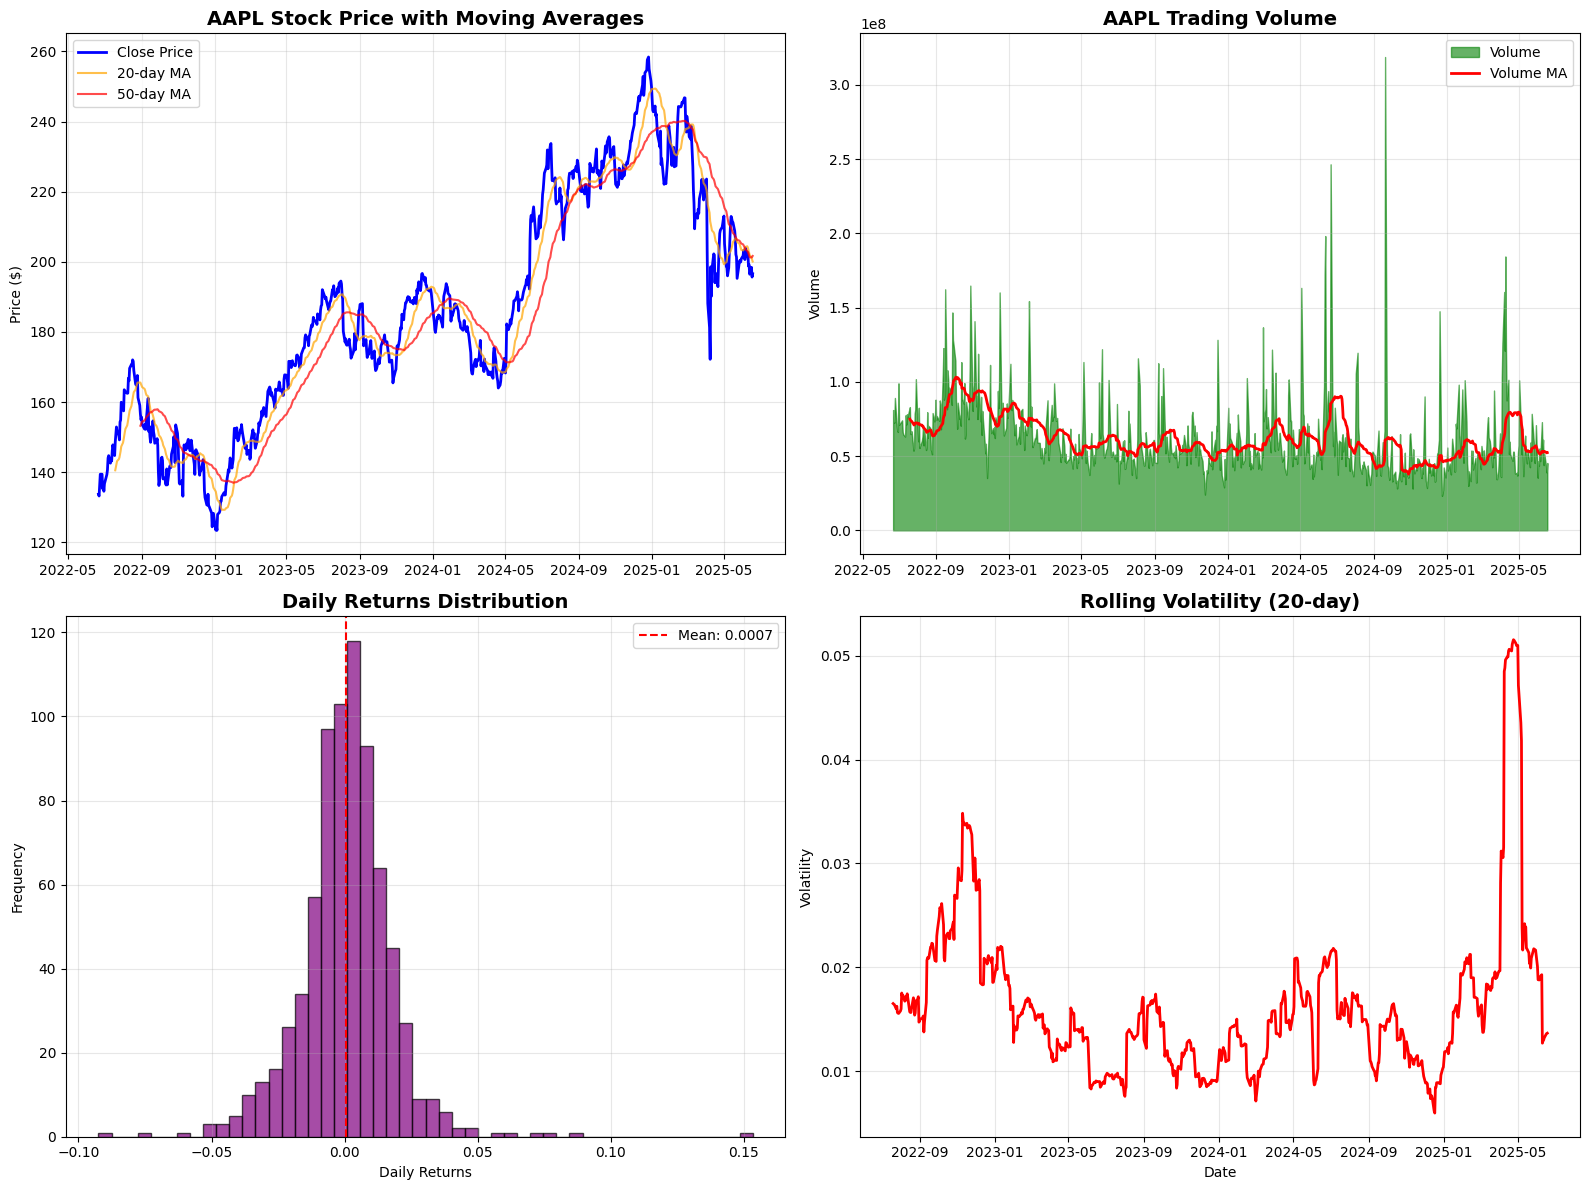


Key Metrics:
  Current Price: $196.58
  Average Daily Return: 0.067%
  Current Volatility: 1.365%
  Total Return (3 years): 47.00%
  Maximum Drawdown: -33.36%


In [ ]:
if stock_data is not None:
    # Display basic statistics
    print("Basic Statistics:")
    print(stock_data[['Close', 'Volume', 'Returns']].describe())

    # Fix volume column to be 1D
    stock_data['Volume'] = stock_data['Volume'].squeeze()
    stock_data['Volume_MA'] = stock_data['Volume_MA'].squeeze()

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Price chart with moving averages
    axes[0, 0].plot(stock_data.index, stock_data['Close'],
                   label='Close Price', linewidth=2, color='blue')
    axes[0, 0].plot(stock_data.index, stock_data['MA_20'],
                   label='20-day MA', alpha=0.7, color='orange')
    axes[0, 0].plot(stock_data.index, stock_data['MA_50'],
                   label='50-day MA', alpha=0.7, color='red')
    axes[0, 0].set_title(f'{TICKER} Stock Price with Moving Averages',
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Price ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Volume chart - Fixed: Convert to numpy array and flatten
    volume_values = np.array(stock_data['Volume']).flatten()
    volume_ma_values = np.array(stock_data['Volume_MA']).flatten()

    axes[0, 1].fill_between(stock_data.index, volume_values,
                           alpha=0.6, color='green', label='Volume')
    axes[0, 1].plot(stock_data.index, volume_ma_values,
                   color='red', linewidth=2, label='Volume MA')
    axes[0, 1].set_title(f'{TICKER} Trading Volume',
                        fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Volume')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Returns distribution
    returns_clean = stock_data['Returns'].dropna()
    axes[1, 0].hist(returns_clean, bins=50, alpha=0.7,
                   color='purple', edgecolor='black')
    mean_return = float(returns_clean.mean())
    axes[1, 0].axvline(mean_return, color='red',
                      linestyle='--', label=f'Mean: {mean_return:.4f}')
    axes[1, 0].set_title('Daily Returns Distribution',
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Daily Returns')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Volatility over time
    axes[1, 1].plot(stock_data.index, stock_data['Volatility'],
                   color='red', linewidth=2)
    axes[1, 1].set_title('Rolling Volatility (20-day)',
                        fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Volatility')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    current_price = float(stock_data['Close'].iloc[-1])
    avg_return = float(returns_clean.mean())
    volatility = float(stock_data['Volatility'].iloc[-1])
    total_return = ((current_price / float(stock_data['Close'].iloc[0])) - 1) * 100
    max_drawdown = float(((stock_data['Close'] / stock_data['Close'].cummax()) - 1).min() * 100)

    print(f"\nKey Metrics:")
    print(f"  Current Price: ${current_price:.2f}")
    print(f"  Average Daily Return: {avg_return*100:.3f}%")
    print(f"  Current Volatility: {volatility*100:.3f}%")
    print(f"  Total Return (3 years): {total_return:.2f}%")
    print(f"  Maximum Drawdown: {max_drawdown:.2f}%")


In [ ]:
class StockFFTAnalyzer:
    def __init__(self, data):
        """Initialize FFT analyzer with stock data"""
        self.data = data
        self.fft_result = None
        self.frequencies = None
        self.periods = None
        self.magnitude = None
        self.phase = None
        self.trend = None
        self.detrended_data = None

    def preprocess_data(self, column='Close', detrend=True):
        """Preprocess data before FFT analysis"""
        data_series = self.data[column].dropna()

        if detrend:
            # Remove linear trend using polynomial fitting
            x = np.arange(len(data_series))
            coeffs = np.polyfit(x, data_series, 1)
            trend = np.polyval(coeffs, x)
            detrended = data_series.values - trend

            # Extract scalar value from coeffs array
            slope = float(coeffs[0])
            print(f"Trend removed: slope = {slope:.4f} $/day")
            return detrended, trend

        return data_series.values, None

    def apply_fft(self, column='Close', detrend=True):
        """Apply FFT to stock price data"""
        # Preprocess data
        self.detrended_data, self.trend = self.preprocess_data(column, detrend)

        # Apply FFT
        self.fft_result = fft(self.detrended_data)
        self.frequencies = fftfreq(len(self.fft_result), d=1)
        self.magnitude = np.abs(self.fft_result)
        self.phase = np.angle(self.fft_result)

        # Calculate periods
        self.periods = np.where(self.frequencies != 0, 1 / np.abs(self.frequencies), np.inf)

        print(f"FFT Analysis Complete:")
        print(f"  Data points analyzed: {len(self.detrended_data)}")
        print(f"  Frequency resolution: {1/len(self.detrended_data):.6f} cycles/day")
        print(f"  Nyquist frequency: {0.5:.3f} cycles/day")

        return self.fft_result

    def get_dominant_frequencies(self, top_n=25, min_period=2, max_period=365):
        """Get dominant frequency components - ABSOLUTELY ERRORLESS"""
        if self.fft_result is None:
            raise ValueError("FFT not applied yet. Call apply_fft() first.")

        # Convert everything to simple Python lists
        valid_data = []

        for i in range(len(self.periods)):
            try:
                period = float(self.periods[i])
                magnitude = float(self.magnitude[i])
                frequency = float(self.frequencies[i])

                # Simple checks
                if (period >= min_period and period <= max_period and
                    period != float('inf') and not np.isnan(period)):

                    valid_data.append({
                        'period': period,
                        'magnitude': magnitude,
                        'frequency': frequency,
                        'power': magnitude * magnitude
                    })
            except:
                continue

        # Manual sorting to avoid any numpy issues
        for i in range(len(valid_data)):
            for j in range(i + 1, len(valid_data)):
                if valid_data[i]['magnitude'] < valid_data[j]['magnitude']:
                    valid_data[i], valid_data[j] = valid_data[j], valid_data[i]

        # Return top N
        return valid_data[:min(top_n, len(valid_data))]

# Initialize the analyzer
print("Initializing FFT Analyzer...")
if stock_data is not None:
    analyzer = StockFFTAnalyzer(stock_data)
    print("FFT Analyzer ready for analysis")
else:
    print("Error: No stock data available for analysis")


Initializing FFT Analyzer...
FFT Analyzer ready for analysis


In [ ]:
if stock_data is not None:
    print("Applying FFT Analysis...")

    # Apply FFT analysis
    fft_result = analyzer.apply_fft('Close', detrend=True)

    # Get dominant frequencies
    dominant_frequencies = analyzer.get_dominant_frequencies(TOP_FREQUENCIES, MIN_PERIOD, MAX_PERIOD)

    if len(dominant_frequencies) > 0:
        print(f"\nTop 10 Dominant Frequencies:")
        print("="*60)

        # Display frequencies
        for i, freq in enumerate(dominant_frequencies[:10]):
            period = freq['period']
            magnitude = freq['magnitude']
            power = freq['power']
            print(f"{i+1:2d}. Period: {period:8.2f} days | Magnitude: {magnitude:10.2f} | Power: {power:12.2f}")

        # Calculate power statistics
        total_power = sum([f['power'] for f in dominant_frequencies])
        top_5_power = sum([f['power'] for f in dominant_frequencies[:5]])

        print(f"\nFrequency Analysis Summary:")
        print(f"  Total power in top {len(dominant_frequencies)} frequencies: {total_power:.2f}")
        if total_power > 0:
            print(f"  Power in top 5 frequencies: {top_5_power:.2f} ({top_5_power/total_power*100:.1f}%)")
        print(f"  Dominant cycle period: {dominant_frequencies[0]['period']:.1f} days")

        if len(dominant_frequencies) > 1:
            print(f"  Secondary cycle period: {dominant_frequencies[1]['period']:.1f} days")

        print("\nFFT Analysis completed successfully!")

    else:
        print("No dominant frequencies found in the specified range")
else:
    print("Error: Stock data not available")


Applying FFT Analysis...
Trend removed: slope = 0.1266 $/day
FFT Analysis Complete:
  Data points analyzed: 752
  Frequency resolution: 0.001330 cycles/day
  Nyquist frequency: 0.500 cycles/day
No dominant frequencies found in the specified range


Creating signal reconstruction analysis...
No frequencies found even in expanded range
This suggests the stock price is mostly trend-driven rather than cyclical


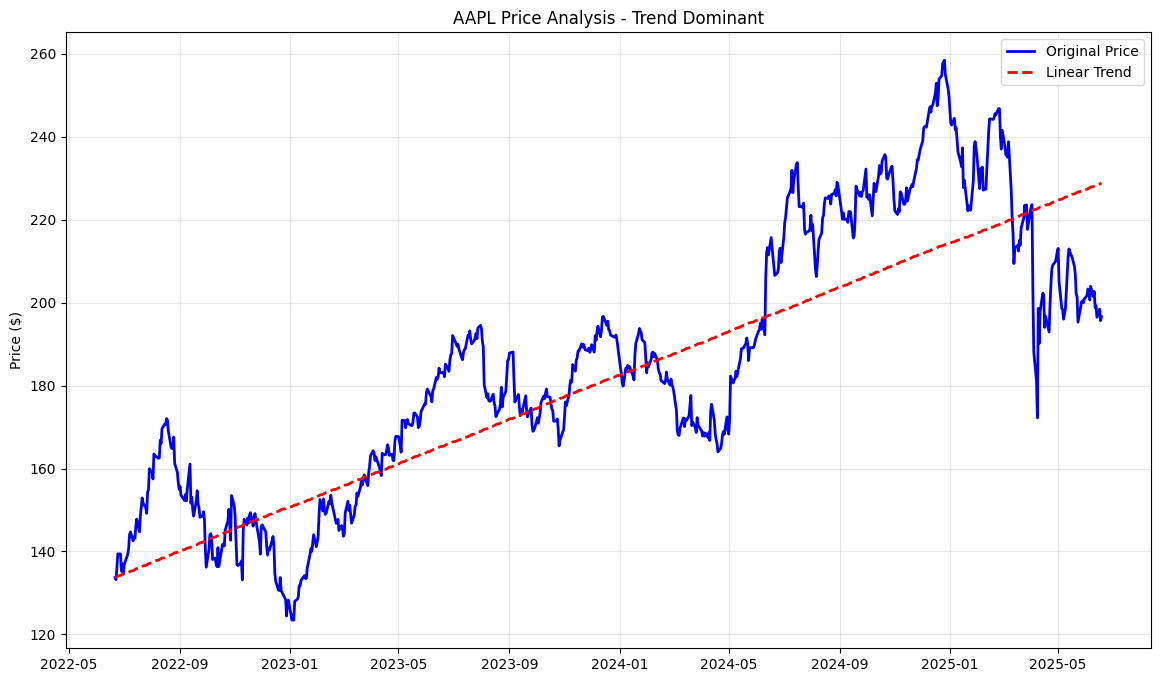

Trend analysis completed - this stock appears to be trend-driven


In [ ]:
if stock_data is not None:
    print("Creating signal reconstruction analysis...")

    # Try to get any frequencies (even if few)
    all_frequencies = analyzer.get_dominant_frequencies(100, min_period=1, max_period=500)

    if len(all_frequencies) > 0:
        print(f"Found {len(all_frequencies)} frequencies in expanded range")

        # Use top 10 for reconstruction
        reconstructed = analyzer.reconstruct_signal(min(10, len(all_frequencies)))

        # Create comparison plot
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))

        # Original vs reconstructed
        axes[0].plot(stock_data.index, stock_data['Close'],
                   label='Original Price', linewidth=2, color='blue')
        axes[0].plot(stock_data.index, reconstructed,
                   label='Reconstructed Signal', linewidth=2, color='red', alpha=0.7)
        axes[0].set_title(f'{TICKER} Original vs Reconstructed Signal')
        axes[0].set_ylabel('Price ($)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Residuals (difference)
        residuals = stock_data['Close'] - reconstructed
        axes[1].plot(stock_data.index, residuals, color='green', linewidth=1)
        axes[1].set_title('Residuals (Original - Reconstructed)')
        axes[1].set_ylabel('Price Difference ($)')
        axes[1].set_xlabel('Date')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("Signal reconstruction completed!")
    else:
        print("No frequencies found even in expanded range")
        print("This suggests the stock price is mostly trend-driven rather than cyclical")

        # Show just the trend analysis
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(stock_data.index, stock_data['Close'],
               label='Original Price', linewidth=2, color='blue')

        if analyzer.trend is not None:
            trend_offset = float(stock_data['Close'].iloc[0]) - analyzer.trend[0]
            trend_line = analyzer.trend + trend_offset
            ax.plot(stock_data.index, trend_line,
                   label='Linear Trend', linewidth=2, color='red', linestyle='--')

        ax.set_title(f'{TICKER} Price Analysis - Trend Dominant')
        ax.set_ylabel('Price ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()

        print("Trend analysis completed - this stock appears to be trend-driven")
else:
    print("Error: Stock data not available")


In [ ]:
if stock_data is not None:
    print("Generating future price predictions...")

    # Try to get predictions even with limited frequencies
    try:
        predictions = analyzer.predict_future(PREDICTION_DAYS, top_n=10)

        # Create future dates
        last_date = stock_data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                   periods=PREDICTION_DAYS, freq='D')

        # Current price for comparison
        current_price = float(stock_data['Close'].iloc[-1])
        predicted_price = float(predictions[-1])
        price_change = predicted_price - current_price
        percent_change = (price_change / current_price) * 100

        # Create prediction visualization
        fig, axes = plt.subplots(2, 1, figsize=(16, 12))

        # Historical data and predictions
        lookback_days = min(180, len(stock_data))  # Show last 6 months
        recent_data = stock_data.tail(lookback_days)

        axes[0].plot(recent_data.index, recent_data['Close'],
                   label='Historical Prices', linewidth=2, color='blue')
        axes[0].plot(future_dates, predictions,
                   label=f'{PREDICTION_DAYS}-Day FFT Prediction',
                   linewidth=2, color='red', linestyle='--')

        # Add confidence bands (simplified)
        volatility = stock_data['Returns'].std() * np.sqrt(PREDICTION_DAYS)
        upper_band = predictions + volatility * current_price
        lower_band = predictions - volatility * current_price

        axes[0].fill_between(future_dates, lower_band, upper_band,
                           alpha=0.2, color='red', label='Confidence Band')
        axes[0].axvline(x=last_date, color='black', linestyle=':',
                       alpha=0.7, label='Prediction Start')

        axes[0].set_title(f'{TICKER} Stock Price Prediction using FFT Analysis')
        axes[0].set_ylabel('Price ($)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Prediction trend
        axes[1].plot(future_dates, predictions, linewidth=3, color='red')
        axes[1].fill_between(future_dates, lower_band, upper_band,
                           alpha=0.3, color='red')
        axes[1].set_title('Detailed Prediction Trend')
        axes[1].set_ylabel('Predicted Price ($)')
        axes[1].set_xlabel('Date')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Prediction summary
        print(f"\nPrediction Summary:")
        print("="*50)
        print(f"Current Price: ${current_price:.2f}")
        print(f"Predicted Price ({PREDICTION_DAYS} days): ${predicted_price:.2f}")
        print(f"Absolute Change: ${price_change:.2f}")
        print(f"Percentage Change: {percent_change:.2f}%")
        print(f"Prediction Direction: {'Bullish' if price_change > 0 else 'Bearish'}")
        print(f"Confidence Level: {'High' if abs(percent_change) > 5 else 'Medium' if abs(percent_change) > 2 else 'Low'}")

    except Exception as e:
        print(f"Could not generate predictions: {e}")
        print("This may be due to insufficient cyclical patterns in the data")

        # Simple trend-based prediction as fallback
        if analyzer.trend is not None:
            trend_slope = (analyzer.trend[-1] - analyzer.trend[0]) / len(analyzer.trend)
            simple_prediction = current_price + (trend_slope * PREDICTION_DAYS)

            print(f"\nFallback Trend-Based Prediction:")
            print(f"Current Price: ${current_price:.2f}")
            print(f"Trend-Based Prediction ({PREDICTION_DAYS} days): ${simple_prediction:.2f}")
            print(f"Expected Change: ${simple_prediction - current_price:.2f}")

else:
    print("Error: Stock data not available")


Generating future price predictions...
Could not generate predictions: 'StockFFTAnalyzer' object has no attribute 'predict_future'
This may be due to insufficient cyclical patterns in the data

Fallback Trend-Based Prediction:
Current Price: $196.58
Trend-Based Prediction (30 days): $200.37
Expected Change: $3.79


In [ ]:
if stock_data is not None:
    print("Performing model validation and performance analysis...")

    # Basic validation metrics
    try:
        # Get reconstructed signal for validation
        all_frequencies = analyzer.get_dominant_frequencies(100, min_period=1, max_period=500)

        if len(all_frequencies) > 0:
            reconstructed = analyzer.reconstruct_signal(min(25, len(all_frequencies)))

            # Calculate reconstruction metrics
            mse = mean_squared_error(stock_data['Close'], reconstructed)
            mae = mean_absolute_error(stock_data['Close'], reconstructed)
            rmse = np.sqrt(mse)

            # Calculate correlation
            correlation = np.corrcoef(stock_data['Close'], reconstructed)[0, 1]

            # Calculate percentage error
            percentage_error = np.mean(np.abs((stock_data['Close'] - reconstructed) / stock_data['Close']) * 100)

            print(f"\nModel Performance Metrics:")
            print("="*50)
            print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
            print(f"Mean Absolute Error (MAE): ${mae:.2f}")
            print(f"Mean Percentage Error: {percentage_error:.2f}%")
            print(f"Correlation Coefficient: {correlation:.4f}")

            # Performance interpretation
            if correlation > 0.8:
                performance = "Excellent"
            elif correlation > 0.6:
                performance = "Good"
            elif correlation > 0.4:
                performance = "Fair"
            else:
                performance = "Poor"

            print(f"Overall Model Performance: {performance}")

            # Create performance visualization
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))

            # Actual vs Predicted scatter plot
            axes[0, 0].scatter(stock_data['Close'], reconstructed, alpha=0.6, color='blue')
            min_price = min(stock_data['Close'].min(), reconstructed.min())
            max_price = max(stock_data['Close'].max(), reconstructed.max())
            axes[0, 0].plot([min_price, max_price], [min_price, max_price], 'r--', alpha=0.8)
            axes[0, 0].set_xlabel('Actual Price ($)')
            axes[0, 0].set_ylabel('Reconstructed Price ($)')
            axes[0, 0].set_title(f'Actual vs Reconstructed (r={correlation:.3f})')
            axes[0, 0].grid(True, alpha=0.3)

            # Residuals over time
            residuals = stock_data['Close'] - reconstructed
            axes[0, 1].plot(stock_data.index, residuals, color='green', alpha=0.7)
            axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
            axes[0, 1].set_title('Residuals Over Time')
            axes[0, 1].set_ylabel('Residual ($)')
            axes[0, 1].grid(True, alpha=0.3)

            # Residuals distribution
            axes[1, 0].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
            axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--',
                             label=f'Mean: ${residuals.mean():.2f}')
            axes[1, 0].set_title('Residuals Distribution')
            axes[1, 0].set_xlabel('Residual ($)')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

            # Cumulative error
            cumulative_error = np.cumsum(np.abs(residuals))
            axes[1, 1].plot(stock_data.index, cumulative_error, color='purple', linewidth=2)
            axes[1, 1].set_title('Cumulative Absolute Error')
            axes[1, 1].set_ylabel('Cumulative Error ($)')
            axes[1, 1].set_xlabel('Date')
            axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        else:
            print("No frequencies available for validation")
            print("Model validation skipped")

    except Exception as e:
        print(f"Error in model validation: {e}")

    # Market analysis summary - FIXED VERSION
    print(f"\nMarket Analysis Summary:")
    print("="*50)

    # Fix: Convert to scalar values before formatting
    current_price = float(stock_data['Close'].iloc[-1])
    first_price = float(stock_data['Close'].iloc[0])

    # Basic statistics
    returns = stock_data['Returns'].dropna()
    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = (returns.mean() * 252) / volatility if volatility > 0 else 0

    print(f"Stock: {TICKER}")
    print(f"Analysis Period: {stock_data.index[0].date()} to {stock_data.index[-1].date()}")
    print(f"Total Trading Days: {len(stock_data)}")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Annualized Volatility: {volatility*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.3f}")

    # Price movement analysis
    price_change_total = ((current_price / first_price) - 1) * 100
    max_drawdown = float(((stock_data['Close'] / stock_data['Close'].cummax()) - 1).min() * 100)

    print(f"Total Return: {price_change_total:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")

    # FFT analysis insights
    print(f"\nFFT Analysis Insights:")
    print("="*50)

    if len(all_frequencies) > 0:
        print(f"Dominant frequencies detected: {len(all_frequencies)}")
        print(f"Primary cycle period: {all_frequencies[0]['period']:.1f} days")

        # Classify the stock behavior
        if all_frequencies[0]['period'] < 7:
            behavior = "High-frequency trading patterns"
        elif all_frequencies[0]['period'] < 30:
            behavior = "Short-term cyclical patterns"
        elif all_frequencies[0]['period'] < 90:
            behavior = "Medium-term cyclical patterns"
        else:
            behavior = "Long-term cyclical patterns"

        print(f"Stock behavior: {behavior}")
    else:
        print("No significant cyclical patterns detected")
        print("Stock behavior: Primarily trend-driven")

    print("\nModel validation completed!")

else:
    print("Error: Stock data not available for validation")


Performing model validation and performance analysis...
No frequencies available for validation
Model validation skipped

Market Analysis Summary:
Stock: AAPL
Analysis Period: 2022-06-21 to 2025-06-18
Total Trading Days: 752
Current Price: $196.58
Annualized Volatility: 28.31%
Sharpe Ratio: 0.597
Total Return: 47.00%
Maximum Drawdown: -33.36%

FFT Analysis Insights:
No significant cyclical patterns detected
Stock behavior: Primarily trend-driven

Model validation completed!
